### Detect Level Ice Tests

##### NOTES for NILS

We're pulling our level ice theory from Von Abedyll et al. and Rabenstein et al., which were designed for very small data granularity. While that is true of IS2 as well, there are actually relatively few inter-return distances that are less than 100 meters. As such we adjust the gradient thresholds from the papers above by scaling them by the ratio of 100m to the actual distance between the points. 

This notebook defines the functions needs to calculate the level ice mask, plots the output and the adaptive thresholds along with the calculated gradients, and test the integration of the level ice function with the original track-reading function.

### Import Library and define functions

In [88]:
import xarray as xr
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import lagrange

Set up some testing data

In [2]:
file = '/glade/scratch/mollyw/external_data/ICESat-2/freeboard/2019.01.01/ATL10-01_20190101005132_00550201_005_02.h5'
track = 'gt1r'

Define functions

In [3]:
def read_track(file, track):
    with h5py.File(file, mode='r') as f:
        latvar = f['/%s/freeboard_beam_segment/beam_freeboard/latitude' % track]
        latitude = latvar[:]
    
        # access the longitude
        lonvar = f['/%s/freeboard_beam_segment/beam_freeboard/longitude' % track]
        longitude = lonvar[:]

        # access the freeboard values 
        datavar = f['/%s/freeboard_beam_segment/beam_freeboard/beam_fb_height' % track]
        data = datavar[:]

        # access the freeboard uncertainty
        unc_var = f['/%s/freeboard_beam_segment/beam_freeboard/beam_fb_sigma' % track]
        unc = unc_var[:]

        # access the open ocean mask
        mask_var = f['/%s/freeboard_beam_segment/height_segments/height_segment_ssh_flag' % track]
        mask = mask_var[:]

        # access the surface type classification
        surf_var = f['/%s/freeboard_beam_segment/height_segments/height_segment_type' % track]
        surf = surf_var[:]

        #handle FillValue
        _FillValue = datavar.attrs['_FillValue']
        data[data == _FillValue] = np.nan
        unc[unc == _FillValue] = np.nan

        # collect time information
        timevar = f['/%s/freeboard_beam_segment/delta_time' % track]
        time = timevar[:]

        return data, latitude, longitude


In [4]:
def haversine_distance(x1, x2, y1, y2):

    dist = 2*np.arcsin(np.sqrt(np.sin((x1 - y1)/2)**2 +
                               np.cos(x1)*np.cos(y1)*np.sin((x2-y2)/2)**2))
    return dist

In [5]:
def latlon2dist(data, latitude, longitude):
        distances = []
        for i in range(0, len(data)-1):
                x1 = latitude[i]
                y1 = longitude[i]

                x2 = latitude[i+1]
                y2 = longitude[i+1]

                dist = 1000 * haversine_distance(x1, x2, y1, y2)
                distances.append(dist)
                
        # says that the distance between two points aligns with the second data point
        distances = np.insert(distances, 0, 0)
        
        return distances

In [57]:
def create_mask(data, distances):
    
    # calculate the gradient of the data
    gradient = np.gradient(data)

    # create mask 
    mask = []
    thresholds = []
    for x in range(0, len(gradient)):
        # determine "smart" threshold
        if np.isnan(gradient[x]):
            grad_thresh = np.nan
        elif distances[x] < 100:
            # use the 100m threshold for any section that is less that 100m
            grad_thresh = 0.4
        else:
            # otherwise, lower the threshold by the weighted distance between points
            grad_thresh = 0.4 * 100/distances[x]
            
        # store gradient thresholds for examination later
        thresholds.append(grad_thresh)
        
        # if the data was NaN, the mask is NaN
        if np.isnan(gradient[x]):
            mask.append(np.nan)
        # if the gradient is greater than the threshold, assign it 0 (False)
        elif abs(gradient[x]) > grad_thresh:
            mask.append(0)
        # else, assign the mask 1 (True)
        else:
            mask.append(1)
            
    for x in range(0, len(mask)):
        # both distance and the mask use the right end point of the section to indicate level or not-level
        if distances[x] < 100 and mask[x] == 1:
            mask = check_neighbors(x, distances, mask)

    return mask, thresholds, gradient

def check_neighbors(x, distances, mask):
    
    # we are looking as a segment that has been marked level but is less than 100 m long
    
    # check the segment to the left
    if x != 0:
        seg_left = mask[x-1]
        
        if seg_left != 1:
            # if the previous segment is not level, set this one not level...
            mask[x] = 0
    
    # unless the segment to the right is level and long enough.
    if x != (len(mask)-1):
        seg_right = mask[x+1]
        seg_right_len = distances[x+1]
    
        if seg_right != 1:
            # if the next segment to the right is not level, set this one not level 
            mask[x] = 0
        elif seg_right == 1 and seg_right_len < 100:
            # if the next segment is level but less than 100m long, test added lengths
            if seg_right_len + distances[x] < 100:
                # if added lengths are still less than 100m, set not level
                mask[x] = 0
        else:
            pass
    
    return mask

In [58]:
def detect_level_ice(data, latitude, longitude):
    
    # calculate the distances between points
    distances = latlon2dist(data, latitude, longitude)

    mask, thresholds, gradient = create_mask(data, distances)

    return mask, thresholds, gradient, distances

In [108]:
def read_track_with_mask(file, track):
    with h5py.File(file, mode='r') as f:
        latvar = f['/%s/freeboard_beam_segment/beam_freeboard/latitude' % track]
        latitude = latvar[:]
    
        # access the longitude
        lonvar = f['/%s/freeboard_beam_segment/beam_freeboard/longitude' % track]
        longitude = lonvar[:]

        # access the freeboard values 
        datavar = f['/%s/freeboard_beam_segment/beam_freeboard/beam_fb_height' % track]
        data = datavar[:]

        # access the freeboard uncertainty
        unc_var = f['/%s/freeboard_beam_segment/beam_freeboard/beam_fb_sigma' % track]
        unc = unc_var[:]

        # access the open ocean mask
        mask_var = f['/%s/freeboard_beam_segment/height_segments/height_segment_ssh_flag' % track]
        mask = mask_var[:]

        # access the surface type classification
        surf_var = f['/%s/freeboard_beam_segment/height_segments/height_segment_type' % track]
        surf = surf_var[:]

        #handle FillValue
        _FillValue = datavar.attrs['_FillValue']
        data[data == _FillValue] = np.nan
        unc[unc == _FillValue] = np.nan

        # collect time information
        timevar = f['/%s/freeboard_beam_segment/delta_time' % track]
        time = timevar[:]
        
        level_mask, thresholds, gradient, distances = detect_level_ice(data, latitude, longitude)

        return data, latitude, longitude, level_mask

### Demonstrate test case

Read track

In [47]:
data, lat, lon = read_track(file, track)

Deploy function

In [59]:
mask, thresholds, gradient, distances = detect_level_ice(data, lat, lon)

Plot mask

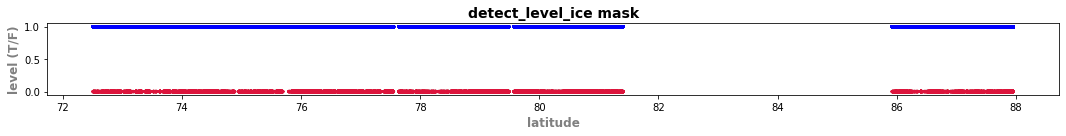

In [67]:
fig = plt.figure(figsize=(15,2))
cmap = mpl.colors.ListedColormap(['crimson', 'blue'])
plt.scatter(lat, mask, s = 5, c = mask, cmap = cmap, facecolor=None)
# plt.colorbar()

plt.xlabel('latitude', fontweight='bold', fontsize=12, color = 'grey')
plt.ylabel('level (T/F)', fontweight='bold', fontsize=12, color = 'grey')
plt.title('detect_level_ice mask', fontweight='bold', fontsize=14)
# plt.xlim([76,78])
plt.tight_layout()

colormap represents the associated gradient between points


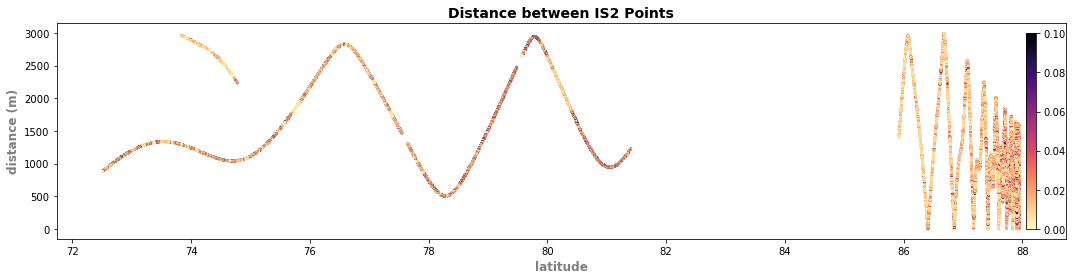

In [113]:
fig = plt.figure(figsize=(15,4))

plt.scatter(lat, distances, s = 2, c = abs(gradient), vmax = 0.1, cmap = 'magma_r', facecolor=None)

plt.colorbar(pad = -0.04, fraction = 0.01)
plt.title('Distance between IS2 Points', fontsize=14, fontweight='bold')
plt.ylabel('distance (m)', fontweight='bold', color = 'grey',fontsize=12)
plt.xlabel('latitude', fontweight='bold', color = 'grey',fontsize=12)
plt.tight_layout()

print('colormap represents the associated gradient between points')

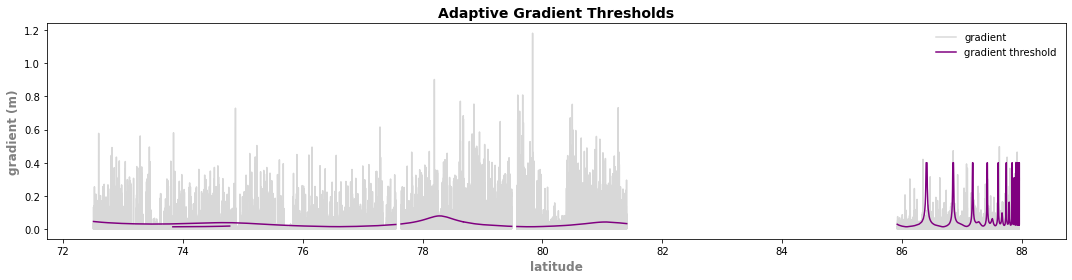

In [117]:
fig = plt.figure(figsize=(15,4))

plt.plot(lat, abs(gradient), color = 'grey', alpha= 0.3, label = 'gradient')
plt.plot(lat, thresholds, color = 'purple', label = 'gradient threshold')

plt.title('Adaptive Gradient Thresholds', fontsize=14, fontweight='bold')
plt.xlabel('latitude', fontweight='bold', fontsize=12, color = 'grey')
plt.ylabel('gradient (m)', fontweight='bold', fontsize=12, color ='grey')
plt.legend(frameon = False)
plt.tight_layout()

In [110]:
data, lat, lon, level_mask = read_track_with_mask(file, track)